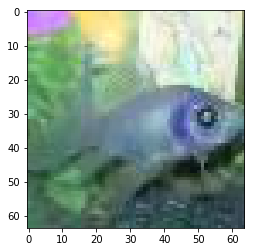

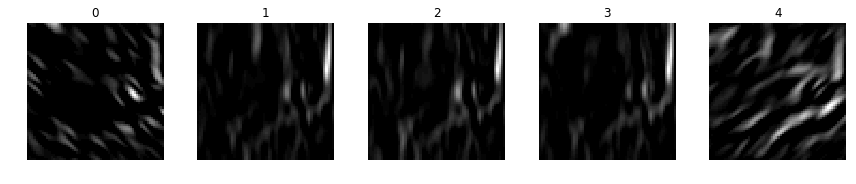

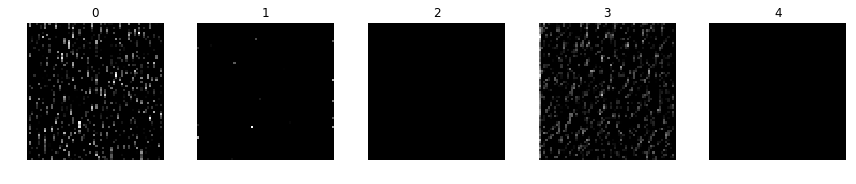

In [62]:
plt.imshow(test_img)
def plot_figures(figures, nrows = 1, ncols=1, labels=None):
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12, 14))
    axs = axs.ravel()
    for index, title in zip(range(len(figures)), figures):
        axs[index].imshow(figures[title], plt.gray())
        if(labels != None):
           axs[index].set_title(labels[index])
        else:
            axs[index].set_title(title)
            
        axs[index].set_axis_off()
        
    plt.tight_layout()

figures = {}
figures2 = {}
labels = {}
my_signs = []
index = 0
for i in range(5):
    #img = cv2.cvtColor(cv2.imread(my_image), cv2.COLOR_BGR2RGB)
    #my_signs.append(f[:,:,i])
    figures[index] = filter_test_img[:,:,i+5]
    figures2[index] = layer_outs[0][0][:,:,i+5]
    #labels[index] = name_values[my_labels[index]][1].decode('ascii')
    index += 1

plot_figures(figures, 1, 5)
plot_figures(figures2, 1, 5)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import csv
import argparse
from sklearn.utils import shuffle
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Conv2D, Cropping2D
from keras.models import load_model
import pandas as pd
from time import time
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import os
import matplotlib.image as mpimg
import cv2
pi = math.pi
%matplotlib inline

Using TensorFlow backend.


In [2]:
def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

def matlab_style_log2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    h1 = h*(x*x + y*y - 2.*sigma*sigma)/(sigma*sigma**2)
    h = h1 - sum(h1)/(shape[0]*shape[1])  
    return h

In [3]:
def makefilter(scale,phasex,phasey,pts,sup):
    gx=gauss1d(3*scale,0,pts[0,:],phasex);
    gy=gauss1d(scale,0,pts[1,:],phasey);
    f=normalise(np.reshape(gx*gy,(sup-1,sup-1)));
    return f

In [4]:
def gauss1d(sigma,mean,x,ord):
  x=x-mean
  num=x*x
  variance=sigma**2
  denom=2*variance
  g=np.exp(-num/denom)/np.sqrt(pi*denom)
  if (ord ==1):
    g=-g*(x/variance)
  elif (ord == 2):
    g=g*((num-variance)/(variance^2));
  return g

In [5]:
def normalise(f):
    f = f-np.mean(f)
    f = f/np.sum(np.abs(f))
    return f

In [6]:
sup = 12
scalex = np.array([1,2])
norient =4
nrotinv = 2
nbar=len(scalex)*norient
nedge=len(scalex)*norient
nf=nbar+nedge+nrotinv
f = np.zeros([sup-1,sup-1,nf])
hsup = (sup-1)/2;

In [7]:
xin = np.arange(-hsup, hsup, 1)
yin = np.arange(hsup,-hsup,-1)
x,y = np.meshgrid(xin,yin)
orgpts=np.array([x, y])
orgpts = np.reshape(orgpts,(2,(sup-1)**2))  

In [8]:
count=0
for scale  in range( len(scalex)):
    for orient in range(norient):
        angle=math.pi*orient/norient;  #Not 2pi as filters have symmetry
        c=math.cos(angle)
        s=math.sin(angle)      
        rotpts=np.matmul(np.array([[c, -s],[s, c]]),orgpts)
        f[:,:,count]=makefilter(scalex[scale],0,1,rotpts,sup)
        f[:,:,count+nedge]=makefilter(scalex[scale],0,2,rotpts,sup)
        count = count+1     

In [9]:
f[:,:,nbar+nedge]=normalise(matlab_style_gauss2D((sup-1,sup-1),10))
f[:,:,nbar+nedge+1]=normalise(matlab_style_log2D((sup-1,sup-1),10))

In [10]:
fh = open("tiny-imagenet-200/wnids.txt")
count = 0
yval = []
for line in fh:
    nl = ''
    for e in line:
        if e == '\n':
            break
        else:
            nl = nl+e
    yval.append(nl)
    #print(line)
    count+=1
fh.close()
print(count)

os.chdir('tiny-imagenet-200/train')
t2 = os.listdir()
cwd = os.getcwd()

class_size = 200
size = 500*class_size

x = []
y = np.zeros([size,class_size])
c = 0
c2 = 0
for d in t2: 
    for f2 in os.listdir(d+'/images'):
        x.append(cwd+'\\'+d+'\\images\\'+f2)
        y[c,c2] = 1
        c = c+1        
    c2+=1    


200


In [11]:
os.chdir('..')
os.chdir('..')

fh = open("tiny-imagenet-200/val/val_annotations.txt")
count = 0
yval = []
yspot = []
for line in fh:
    nl = ''
    nl2 = ''
    for e in line:
        if (e == '\t'):
            count +=1
        elif (count ==0):
            nl2 = nl2 +e
        elif (count == 1): 
            nl = nl+e
        elif count > 1: 
            break
    yval.append(nl)
    yspot.append(nl2)
    #print(line)
    count = 0
fh.close()

os.chdir('tiny-imagenet-200/train')
t3 = os.listdir()

os.chdir('..')
os.chdir('..')

os.chdir('tiny-imagenet-200/val/images')
t2 = os.listdir()
cwd = os.getcwd()

class_size = 200
sizev = 10000

xv = []
yv = np.zeros([sizev,class_size])
c = 0
c2 = 0
for d in yspot:
    xv.append(cwd+'\\'+d)
    yv[c, t3.index(yval[c])] = 1
    c = c+1
    
    

In [19]:
import random

def f_process(img):         
    #imag=preprocess(cv2.imread(img))
    figures = np.empty([64,64,54], dtype='float32')
    for i in range(18):
        figures[:,:,i*3:i*3+3] =  cv2.filter2D(img,-1,f[:,:,i])
    return figures
                
def preprocess(img):
    img_out= img.astype('float32')
    img_out=img_out/255
    return img_out

def generator(x, y, batch_size=128):
    num_samples = len(x)
    x, y = shuffle(x, y)
    while True:
        images = []
        angles = []        
        for offset in range(0, num_samples, batch_size):
            images = []
            batch_y = y[offset:offset + batch_size]
            batch_x = x[offset:offset + batch_size]            
            for z in batch_x:
                images.append(cv2.imread(z))
            for h in batch_y:
                angles.append(h)
            X_train = np.array(images)
            y_train = np.array(batch_y)
            X_train = preprocess(X_train)            
            yield X_train, y_train
 
            
def generator_filter(x, y, batch_size=128):
    num_samples = len(x)
    x, y = shuffle(x, y)
    while True:
        images = []
        angles = []
        figures = np.empty([64,64,54], dtype='float32')      
        for offset in range(0, num_samples, batch_size):
            images = []
            figures = np.empty([64,64,54], dtype='float32')
            batch_y = y[offset:offset + batch_size]
            batch_x = x[offset:offset + batch_size]         
            for z in batch_x:             
                imag=preprocess(cv2.imread(z))
                figures = np.empty([64,64,54], dtype='float32')
                for i in range(18):
                    figures[:,:,i*3:i*3+3] =  cv2.filter2D(imag,-1,f[:,:,i])
                images.append(figures)
            for h in batch_y:
                angles.append(h)
            X_train = np.array(images)
            y_train = np.array(batch_y)
            yield X_train, y_train

train_generator = generator(x,y)
val_generator = generator(xv,yv)
filter_generator = generator_filter(x,y)
val_filter_generator = generator_filter(xv,yv)

In [14]:
os.chdir('..')
os.chdir('..')
os.chdir('..')
from keras.models import model_from_json

with open('filter_model.json', 'r') as fr:
    fm = model_from_json(fr.read())
fm.load_weights('filter_model.h5')

with open('model.json', 'r') as fr:
    m = model_from_json(fr.read())
m.load_weights('model.h5')

In [20]:
test_img=cv2.imread(x[0])
filter_test_img = f_process(test_img)

In [22]:
from keras import backend as K

inp = m.input                                           # input placeholder
outputs = [layer.output for layer in m.layers]          # all layer outputs
functor = K.function([inp, K.learning_phase()], outputs )   # evaluation function

# Testing
test = np.random.random(test_img.shape)[np.newaxis,...]
layer_outs = functor([test, 1.])
#print (layer_outs)

inp = fm.input                                           # input placeholder
outputs = [layer.output for layer in fm.layers]          # all layer outputs
functor = K.function([inp, K.learning_phase()], outputs )   # evaluation function

# Testing
test = np.random.random(filter_test_img.shape)[np.newaxis,...]
filter_layer_outs = functor([test, 1.])


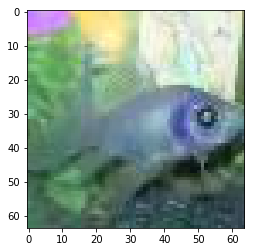

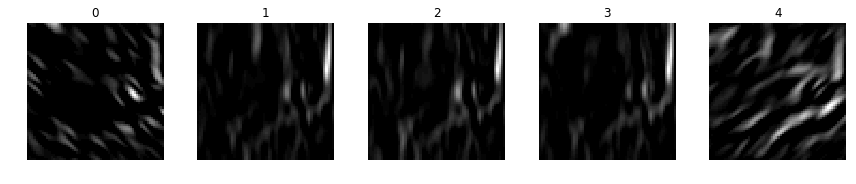

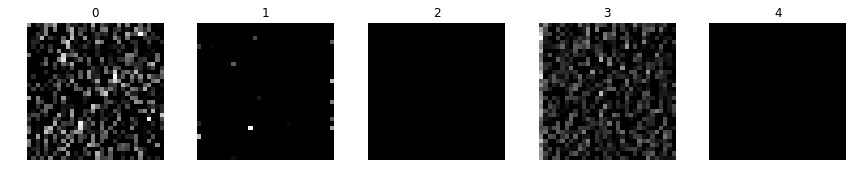